In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchmetrics import Dice
from torchvision.transforms import Resize, RandomCrop
from torchvision.transforms.functional import crop
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt
from pathlib import Path
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights

In [2]:
class UAVIDDataset4K(Dataset):
    def __init__(self, path, is_train=True):
        directory = Path(path)
        if is_train:
            self.images = [
                str(x.absolute()) for x in directory.glob("uavid_train/**/Images/*.png")
            ]
            self.labels = [
                str(x.absolute()) for x in directory.glob("uavid_train/**/Labels/*.png")
            ]
        else:
            self.images = [
                str(x.absolute()) for x in directory.glob("uavid_val/**/Images/*.png")
            ]
            self.labels = [
                str(x.absolute()) for x in directory.glob("uavid_val/**/Labels/*.png")
            ]

        if len(self.images) is not len(self.labels):
            print("Number of images & label are not the same.")
            return

    def __len__(self):
        return len(self.images)

    @staticmethod
    def decode_image(image_path):
        return read_image(image_path)

    @staticmethod
    def resize_image(image):
        resizer = Resize([2160, 3840], antialias="True")
        return resizer(image)

    @staticmethod
    def label_0and1(label):
        return label.type(torch.float32)

    @staticmethod
    def image_0and1(image):
        return (image / 255).type(torch.float32)

    @staticmethod
    def mask_label(label):
        labels = []
        labels.append((label[0] == 0) & (label[1] == 0) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 0) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 64) & (label[2] == 128))
        labels.append((label[0] == 0) & (label[1] == 128) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 128) & (label[2] == 0))
        labels.append((label[0] == 64) & (label[1] == 0) & (label[2] == 128))
        labels.append((label[0] == 192) & (label[1] == 0) & (label[2] == 192))
        labels.append((label[0] == 64) & (label[1] == 64) & (label[2] == 0))
        return torch.stack(labels)

    def __getitem__(self, index):
        image = self.decode_image(self.images[index])
        image = self.resize_image(image)
        image = self.image_0and1(image)

        label = self.decode_image(self.labels[index])
        label = self.resize_image(label)
        label = self.label_0and1(label)
        label = self.mask_label(label)

        return image, label

In [5]:
class UAVIDDataset(Dataset):
    def __init__(self, path, is_train=True):
        directory = Path(path)
        if is_train:
            self.images = [
                str(x.absolute()) for x in directory.glob("train/image/*.png")
            ]
            self.labels = [
                str(x.absolute()) for x in directory.glob("train/label/*.png")
            ]
        else:
            self.images = [
                str(x.absolute()) for x in directory.glob("test/image/*.png")
            ]
            self.labels = [
                str(x.absolute()) for x in directory.glob("test/label/*.png")
            ]

        if len(self.images) != len(self.labels):
            print("Number of images & label are not the same.")
            return

    def __len__(self):
        return len(self.images)

    @staticmethod
    def decode_image(image_path):
        return read_image(image_path)

    @staticmethod
    def resize_image(image):
        resizer = Resize([2160, 3840], antialias="True")
        return resizer(image)

    @staticmethod
    def label_0and1(label):
        return label.type(torch.float32)

    @staticmethod
    def image_0and1(image):
        return (image / 255).type(torch.float32)

    @staticmethod
    def mask_label(label):
        labels = []
        labels.append((label[0] == 0) & (label[1] == 0) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 0) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 64) & (label[2] == 128))
        labels.append((label[0] == 0) & (label[1] == 128) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 128) & (label[2] == 0))
        labels.append((label[0] == 64) & (label[1] == 0) & (label[2] == 128))
        labels.append((label[0] == 192) & (label[1] == 0) & (label[2] == 192))
        labels.append((label[0] == 64) & (label[1] == 64) & (label[2] == 0))
        return torch.stack(labels)

    def __getitem__(self, index):
        image = self.decode_image(self.images[index])
        i, j, h, w = RandomCrop.get_params(image, (256, 256))
        image = self.image_0and1(image)
        label = self.decode_image(self.labels[index])
        label = self.mask_label(label)
        label = self.label_0and1(label)

        # Crop image and label
        image = crop(image, i, j, h, w)
        label = crop(label, i, j, h, w)

        return image, label

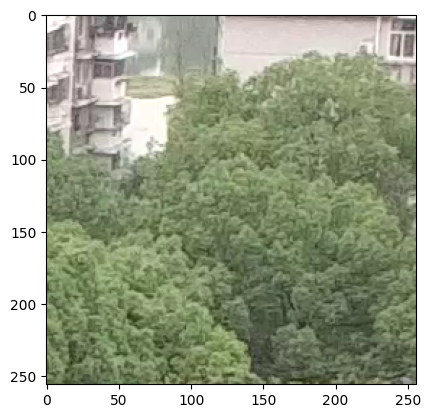

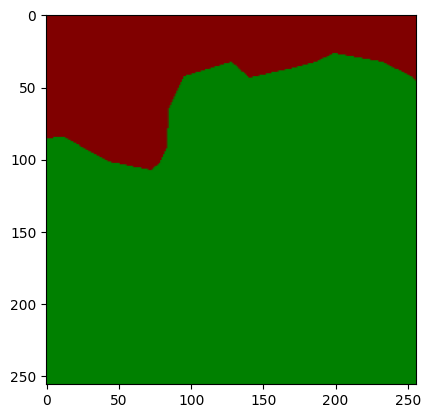

In [7]:
# training_data = UAVIDDataset4K(path="data/uavid_v1.5_official_release_image", is_train=True)
training_data = UAVIDDataset(path="data/processed_dataset/", is_train=True)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
train_feature, train_label = next(iter(train_dataloader))


plt.figure()
plt.imshow(torch.permute(train_feature[0], [1, 2, 0]))

plt.figure()
plt.imshow(torch.permute(train_label[0], [1, 2, 0]))

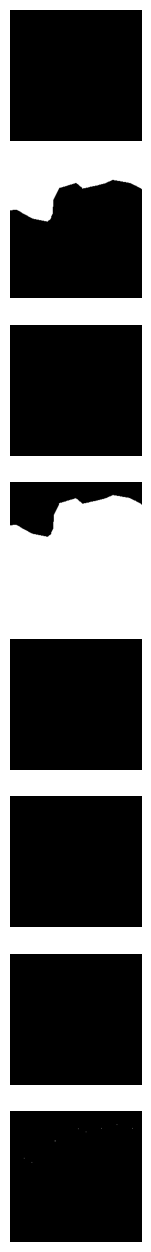

In [8]:
figure, axes = plt.subplots(8, 1, figsize=(9, 16))
splited_image = UAVIDDataset.mask_label(train_label[0]).type(torch.uint8)
for i in range(8):
    axes[i].set_axis_off()
    axes[i].imshow(
        # torch.permute(train_label, [0, 2, 3, 1]).numpy()[0, ..., i],
        splited_image[i],
        cmap="gray",
        vmin=0,
        vmax=1,
    )

In [ ]:
class UNETNetwork(nn.Module):
    def __init__(self, numberClass):
        super().__init__()
        _resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = create_feature_extractor(
            _resnet50,
            {
                "relu": "feat1",
                "layer1": "feat2",
                "layer2": "feat3",
                "layer3": "feat4",
                "layer4": "feat5",
            },
        )
        self.upsample2x1 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.upsample2x2 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.upsample2x3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.upsample2x4 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.upsample2x5 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv5 = nn.Conv2d(
            in_channels=2048,
            out_channels=256,
            kernel_size=3,
            padding=1,
        )
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(
            in_channels=1280,
            out_channels=256,
            kernel_size=3,
            padding=1,
        )
        self.relu6 = nn.ReLU()
        self.conv7 = nn.Conv2d(
            in_channels=768,
            out_channels=256,
            kernel_size=3,
            padding=1,
        )
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(
            in_channels=512,
            out_channels=256,
            kernel_size=3,
            padding=1,
        )
        self.relu8 = nn.ReLU()
        self.conv9 = nn.Conv2d(
            in_channels=320,
            out_channels=256,
            kernel_size=3,
            padding=1,
        )
        self.relu9 = nn.ReLU()
        self.convfinal = nn.Conv2d(
            in_channels=256,
            out_channels=numberClass,
            kernel_size=1,
        )
        self.final_activation = torch.nn.Sigmoid()

    def forward(self, x):
        backbone_output = self.backbone(x)
        feat1, feat2, feat3, feat4, feat5 = (
            backbone_output["feat1"],
            backbone_output["feat2"],
            backbone_output["feat3"],
            backbone_output["feat4"],
            backbone_output["feat5"],
        )
        feat4to6 = self.upsample2x1(self.relu5(self.conv5(feat5)))
        feat3to7 = self.upsample2x2(
            self.relu6(self.conv6(torch.concat([feat4, feat4to6], dim=1)))
        )
        feat2to8 = self.upsample2x3(
            self.relu7(self.conv7(torch.concat([feat3, feat3to7], dim=1)))
        )
        feat1to9 = self.upsample2x4(
            self.relu8(self.conv8(torch.concat([feat2, feat2to8], dim=1)))
        )
        featout = self.upsample2x5(
            self.relu9(self.conv9(torch.concat([feat1, feat1to9], dim=1)))
        )
        return self.final_activation(self.convfinal(featout))

In [ ]:
loss_fn1 = torch.nn.CrossEntropyLoss().to("mps")
loss_fn2 = Dice().to("mps")
model = UNETNetwork(numberClass=8).to("mps")
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [ ]:
def loss_fn(outputs, labels):
    return loss_fn1(outputs, labels) + (1 - loss_fn2(outputs, labels.to(torch.int32)))


for epoch in range(1):
    model.train(True)
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs: torch.Tensor
        labels: torch.Tensor
        inputs, labels = data
        optimizer.zero_grad()

        inputs = inputs.to("mps")
        labels = labels.to("mps")

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()

        if i % 500 == 499:
            print(f"Loss: {running_loss / (i + 1)}")

In [ ]:
train_feature, train_label = next(iter(train_dataloader))

In [ ]:
plt.figure()
model.eval()

with torch.no_grad():
    outputs = model(train_feature.to("mps"))
    outputs = outputs.to("cpu")
    figure, axes = plt.subplots(8, 2, figsize=(9, 9))
    for i in range(8):
        axes[i, 0].set_axis_off()
        axes[i, 0].imshow(
            torch.permute(train_label, [0, 2, 3, 1]).numpy()[1, ..., i],
            cmap="gray",
            vmin=0,
            vmax=1,
        )
        axes[i, 1].set_axis_off()
        axes[i, 1].imshow(
            torch.permute(outputs, [0, 2, 3, 1]).numpy()[1, ..., i],
            cmap="gray",
            vmin=0,
            vmax=1,
        )

In [ ]:
plt.imshow(torch.permute(train_feature, [0, 2, 3, 1])[1])